In [6]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import astropy.units as u

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

In [ ]:
hostname = "GJ 357"

In [7]:
sectors = lk.search_lightcurve(hostname, author='SPOC')

In [8]:
sectors

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 08,2019,SPOC,120,413248763,0.0
1,TESS Sector 35,2021,SPOC,20,413248763,0.0
2,TESS Sector 35,2021,SPOC,120,413248763,0.0
3,TESS Sector 62,2023,SPOC,20,413248763,0.0
4,TESS Sector 62,2023,SPOC,120,413248763,0.0


In [9]:
sector_numbers = []
for sector in sectors.mission: sector_numbers.append(int(sector[-2:]))
sector_numbers = np.array(sector_numbers)
np.argwhere(sector_numbers==62).shape[0]
sectors.exptime[0].value == 120

True

In [10]:
times, fluxes = [], []
for i, secnum in enumerate(sector_numbers): 
    nsectors = np.argwhere(sector_numbers==secnum).shape[0]
    # kludgey way to get high cadence data if it exists, otherwise just normal data
    if nsectors == 1: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    else: 
        if sectors.exptime[i].value == 120: continue
        else: lc_file = lk.search_lightcurve(hostname, sector=secnum,
                                   author="SPOC"
                                  ).download(quality_bitmask="hardest", flux_column="pdcsap_flux")
    lc = lc_file.remove_nans().normalize().remove_outliers()
    time = lc.time.value
    flux = lc.flux
    
    times.append(time)
    fluxes.append(flux)

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/home/hannah/programs/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:407: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [11]:
times

[array([1517.83203947, 1517.8334284 , 1517.83481734, ..., 1542.00180513,
        1542.003194  , 1542.00458288]),
 array([2255.66815312, 2255.6683846 , 2255.66861609, ..., 2279.9839563 ,
        2279.98418777, 2279.98441925]),
 array([2989.4442639 , 2989.44449539, 2989.44472687, ..., 3014.15739426,
        3014.15762574, 3014.15785721])]

In [12]:
time = np.hstack(times)
flux = np.hstack(fluxes)

0.0002314814814814815

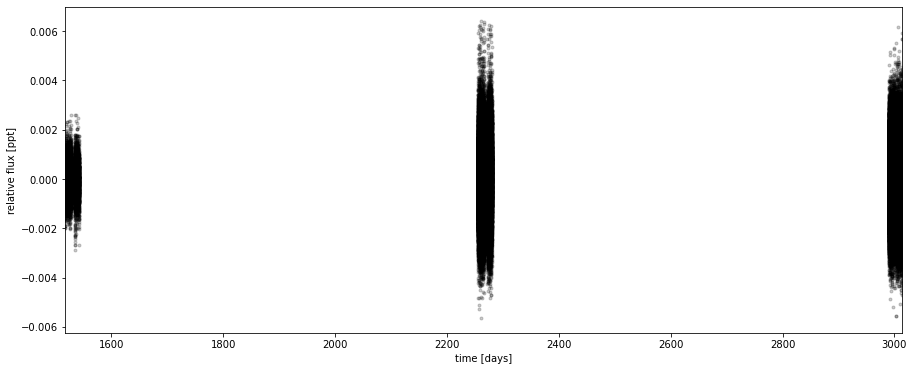

In [15]:
with fits.open(lc_file.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(flux - 1.0, dtype=np.float64)

%matplotlib inline
plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname}')
plt.plot(x, y, ".k", alpha=0.2)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

texp

(1517.8320394705943, 3014.1578572118287)

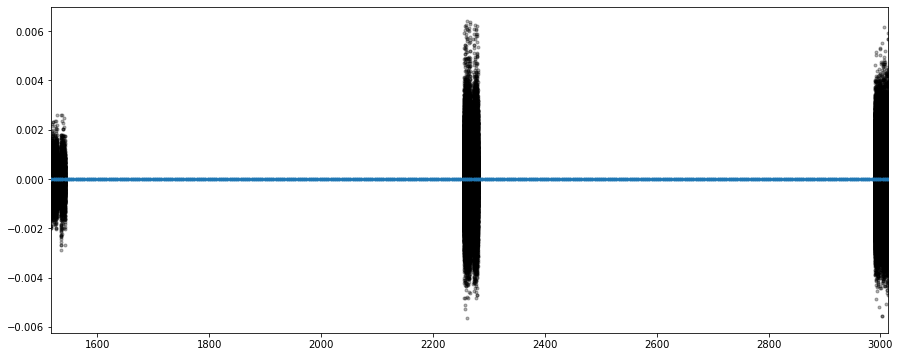

In [16]:
# priors
T0        = 2458517.99862-2457000
T0_unc    = 0.00039
P         = 3.93072
P_unc     = 0.00007
Rp_Rs     = 0.0331
Rp_Rs_unc = 0.0009
depth     = Rp_Rs**2
depth_unc = 2*Rp_Rs*Rp_Rs_unc
R_pl      = (Rp_Rs * 0.337*u.R_sun).to(u.R_earth).value

plt.figure(figsize=(15, 6))
plt.title(f'TESS data of {hostname} with predicted transit times')
plt.plot(x, y, 'k.', alpha=0.3)
n = np.arange(0, 1000)
t = T0 + n*P
plt.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
plt.xlim(x[0], x[-1])

In [17]:
phase_lc = np.linspace(-0.3, 0.3, 100)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=0.001)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from Luque (2019)
        M_star = 0.342, 0.011
        R_star = 0.337, 0.015
        #BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=0.5)
        #m_star = BoundedNormal(
        #    "m_star", mu=M_star[0], sd=M_star[1]
        #)
        #r_star = BoundedNormal(
        #    "r_star", mu=R_star[0], sd=R_star[1]
        #)
        m_star, r_star = M_star[0], R_star[0]

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=T0, sd=T0_unc)
        log_period = pm.Normal("log_period", mu=np.log(P), sd=P_unc)
        period = pm.Deterministic("period", tt.exp(log_period))
        
        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(depth), sigma=depth_unc)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        #         log_r_pl = pm.Normal(
        #             "log_r_pl",
        #             sd=1.0,
        #             mu=0.5 * np.log(1e-3 * np.array(bls_depth))
        #             + np.log(R_star_huang[0]),
        #         )
        #         r_pl = pm.Deterministic("r_pl", tt.exp(log_r_pl))
        #         ror = pm.Deterministic("ror", r_pl / r_star)
        #         b = xo.distributions.ImpactParameter("b", ror=ror)

        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=0.1
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=0.01)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=0.1
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
        )
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.Matern32Term(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        #map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


In [18]:
%matplotlib inline
model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 994012.935764799 -> 994106.6373491742
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 994106.6373491742 -> 994119.6606529313
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: 994119.660652931 -> 994966.1293469492
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: 994966.129346949 -> 994969.1225522946
optimizing logp for variables: [b]


message: Optimization terminated successfully.
logp: 994969.1225522946 -> 994971.7925635587
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: 994971.7925635587 -> 994972.3770937179
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: 994972.377093718 -> 994972.4062320088
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: 994972.4062320088 -> 994976.7495448622
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 994976.7495448622 -> 994984.3741126873


In [24]:
%matplotlib
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(15, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.plot(t, [0 for i in t], '.', color='C2', zorder=1000)
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    #ax.plot(t, [0 for i in t], '.', color='C0', zorder=1000)
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


_ = plot_light_curve(map_soln0, extras0)

Using matplotlib backend: Qt5Agg


In [25]:
#mod = (
#    extras0["gp_pred"]
#    + map_soln0["mean"]
#    + np.sum(extras0["light_curves"], axis=-1)
#)
#resid = y - mod
#rms = np.sqrt(np.median(resid**2))
#mask = np.abs(resid) < 7 * rms

#plt.figure(figsize=(10, 5))
#plt.plot(x, resid, "k", label="data")
#plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
#plt.axhline(0, color="#aaaaaa", lw=1)
#plt.ylabel("residuals [ppt]")
#plt.xlabel("time [days]")
#plt.legend(fontsize=12, loc=3)
#_ = plt.xlim(x.min(), x.max())

In [26]:
#model, map_soln, extras = build_model(mask, map_soln0)
#_ = plot_light_curve(map_soln, extras, mask)

In [27]:
with model0:
    trace = pm.sample(
        tune=500,
        draws=1000,
        start=map_soln0,
        cores=1,
        chains=2,
        #target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, u_star, mean]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 9897 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [28]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        #"r_star",
        #"m_star",
        "u_star",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,0.831,1.732,-2.847,3.086,0.125,0.088,195.0,381.0,1.01
ecc,0.129,0.101,0.000,0.334,0.013,0.011,94.0,71.0,1.02
r_pl,0.010,0.000,0.010,0.011,0.000,0.000,215.0,115.0,1.01
b,0.255,0.145,0.001,0.474,0.011,0.010,139.0,86.0,1.03
t0,1517.999,0.000,1517.998,1518.000,0.000,0.000,429.0,293.0,1.01
period,3.931,0.000,3.931,3.931,0.000,0.000,613.0,746.0,1.00
u_star[0],0.579,0.167,0.255,0.887,0.007,0.005,582.0,573.0,1.01
u_star[1],-0.099,0.225,-0.458,0.347,0.009,0.007,515.0,650.0,1.00
mean,0.000,0.000,-0.000,0.000,0.000,0.000,907.0,934.0,1.01


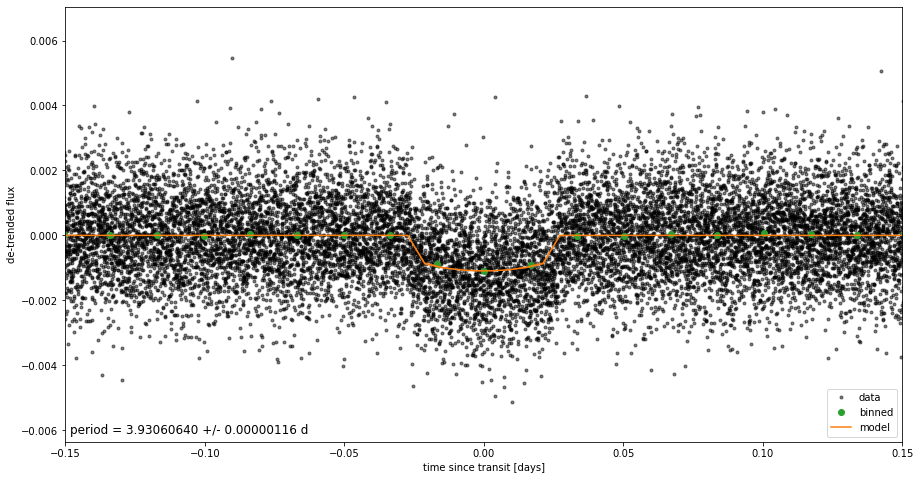

In [34]:
%matplotlib inline
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras0["gp_pred"] + map_soln0["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
plt.figure(figsize=(15, 8))
x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y - gp_mod, ".k", alpha=0.5, label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.8f} +/- {1:.8f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

In [35]:
print("Period:")
print("    ", np.median(flat_samps["period"]), '+/-', np.std(flat_samps["period"]))
print("T0:")
print("    ", np.median(flat_samps["t0"])+2457000, '+/-', np.std(flat_samps["t0"]))
print("ecc:")
print("    ", np.median(flat_samps["ecc"]), '+/-', np.std(flat_samps["ecc"]))

Period:
     3.9306063296116895 +/- <xarray.DataArray 'period' ()>
array(1.16151077e-06)
T0:
     2458517.998911108 +/- <xarray.DataArray 't0' ()>
array(0.00030417)
ecc:
     0.09867499525899563 +/- <xarray.DataArray 'ecc' ()>
array(0.1005172)


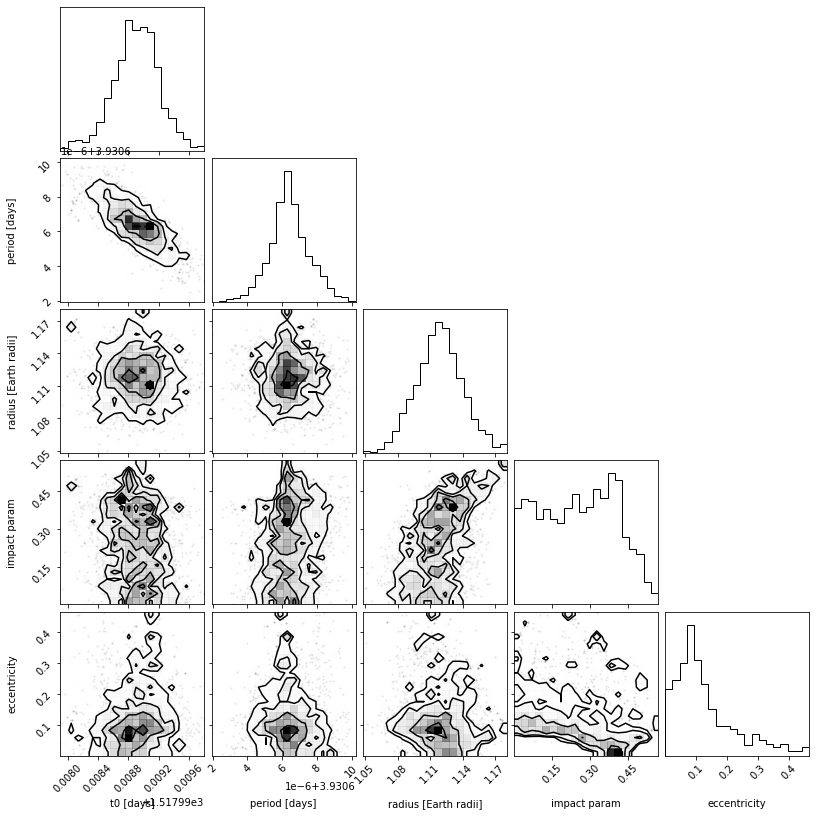

In [31]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["t0", "period", "r_earth", "b", "ecc"],
    labels=[
        "t0 [days]",
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",
    ],
)